In [2]:
import os
import pickle
import repackage
repackage.up()
import os.path as osp
from nuscenes.nuscenes import NuScenes
from tqdm import tqdm
import pandas as pd
import numpy as np
from datasets.nuscenes import NuScenesMultipleRadarMultiSweeps
from utils.labelling import get_sps_labels
from utils.transforms import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
# sps_df = pd.read_json('../sps_nuscenes_more_matches_df.json')
sps_df = pd.read_json('../nuscenes_scenes_df.json')
sps_df.head()

,scene_name,first_frame_datetime,days_since_first_recording,hours_since_first_recording,month,split,closest_scenes,closest_scenes_data
122,scene-0162,1526922463034,0,0.005553,May,trainval,[scene-0665],{'scene-0665': {'scene_token': '45275e709d4a4b...
126,scene-0166,1526922575054,0,0.036670,May,trainval,[scene-0440],{'scene-0440': {'scene_token': '64e1ad8a976542...
127,scene-0167,1526922613046,0,0.047223,May,trainval,"[scene-0079, scene-0653, scene-0442]",{'scene-0079': {'scene_token': '1e4818b3b2354b...
128,scene-0168,1526922652038,0,0.058055,May,trainval,[scene-0444],{'scene-0444': {'scene_token': 'a2e3c0a763c04e...
129,scene-0170,1526922817015,0,0.103882,May,trainval,[scene-0331],{'scene-0331': {'scene_token': '9d1307e95c524c...


In [4]:
ref_frame = None
num_sweeps = 5
ref_sensor = None
apply_dpr = False
filter_points = False
dpr_thresh = 0.75

data_dir = "/shared/data/nuScenes/"
sps_maps_dir = "../output_sw5-dpr0.15-r1_combined_maps/labelled_maps/"

In [5]:

sensors = ["RADAR_FRONT", "RADAR_FRONT_LEFT", "RADAR_FRONT_RIGHT", "RADAR_BACK_LEFT", "RADAR_BACK_RIGHT"]
versions = {'trainval': 'v1.0-trainval', 'test': 'v1.0-test'}
nuscenes_exp = {
    vname : NuScenes(dataroot=data_dir, version=version, verbose=False)\
    for vname,version in versions.items()
}

In [6]:
def extract_data(dataset):
    num_frames = len(dataset)
    local_poses = dataset.local_poses
    global_poses = dataset.global_poses
    ego_timestamps = dataset.timestamps
    all_data = []

    for i in range(num_frames):
        frame_dict = {}
        (pointclouds, sps_scores), calibs, sensors, timestamps = dataset[i]

        for sensor, calib, ts, pcl, scores in zip(sensors, calibs, timestamps, pointclouds, sps_scores):
            frame_dict[sensor] = {
                'calib' : calib,
                'timestamp': ts,
                'pointcloud': pcl,
                'stability_scores': scores
            }
        frame_dict['ego_pose'] = global_poses[i]
        frame_dict['ego_local_pose'] = local_poses[i]
        frame_dict['ego_timestamp'] = ego_timestamps[i]
        all_data.append(frame_dict)
    return all_data

In [6]:
row = sps_df.iloc[0]
ref_scene_name = row['scene_name']
ref_split = row['split']
closest_scenes = row['closest_scenes_data']
seq = int(ref_scene_name.split("-")[-1])


dataset_sequence = NuScenesMultipleRadarMultiSweeps(
    data_dir=data_dir,
    nusc=nuscenes_exp[ref_split],
    sequence=seq,
    sensors=sensors,
    nsweeps=num_sweeps,
    ref_frame=ref_frame,
    ref_sensor=ref_sensor,
    sps_thresh=0.0,
    return_sps_scores=True,
    sps_labels_dir=sps_maps_dir,
    apply_dpr=apply_dpr,
    filter_points=filter_points,
    ransac_threshold=dpr_thresh,
    reformat_pcl=False

)

data = extract_data(dataset_sequence)

In [7]:
print(seq)

162


In [8]:
data[0]['ego_timestamp']

[1526915263.338853,
 1526915263.403805,
 1526915263.358866,
 1526915263.409038,
 1526915263.349147]

In [9]:
data[0]['ego_pose']

array([[ 9.99519025e-01, -3.10116046e-02,  0.00000000e+00,
         2.25583758e+03],
       [ 3.10116046e-02,  9.99519025e-01,  0.00000000e+00,
         8.57782891e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [10]:
data[0].keys()

dict_keys(['RADAR_FRONT', 'RADAR_FRONT_LEFT', 'RADAR_FRONT_RIGHT', 'RADAR_BACK_LEFT', 'RADAR_BACK_RIGHT', 'ego_pose', 'ego_local_pose', 'ego_timestamp'])

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


def plot_pointclouds(sensor_data, ego_pose):
    """
    Plots the pointclouds from all sensors in the global frame with color coding based on stability scores.
    """
    all_points = []
    all_scores = []

    if type(sensor_data) == list:
        for sd, pose in zip(sensor_data, ego_pose):
            for sensor, data in sd.items():
                if sensor == 'ego_pose' or sensor == 'ego_timestamp' or sensor == 'ego_local_pose':
                    continue
                calib_matrix = data['calib']
                pointcloud = data['pointcloud']
                stability_scores = data['stability_scores']
                
                # Transform points from sensor to ego vehicle frame
                ego_frame_points = transform_doppler_points(calib_matrix, pointcloud)
                
                # Transform points from ego vehicle frame to global frame
                global_frame_points = transform_doppler_points(pose, ego_frame_points)
                
                # Append points and their color based on individual stability scores
                all_points.append(global_frame_points)
                all_scores.append(stability_scores)
    
    all_points = np.vstack(all_points)
    all_scores = np.concatenate(all_scores)

    # Create scatter plot
    fig = plt.figure(figsize=(16, 16))

    ax = fig.add_subplot(111)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    sc = ax.scatter(all_points[:, 0], all_points[:, 1], c=all_scores, cmap='RdYlGn', s=0.5)
    
    plt.title('Pointclouds from All Sensors in Global Frame')
    plt.colorbar(sc)
    plt.show()

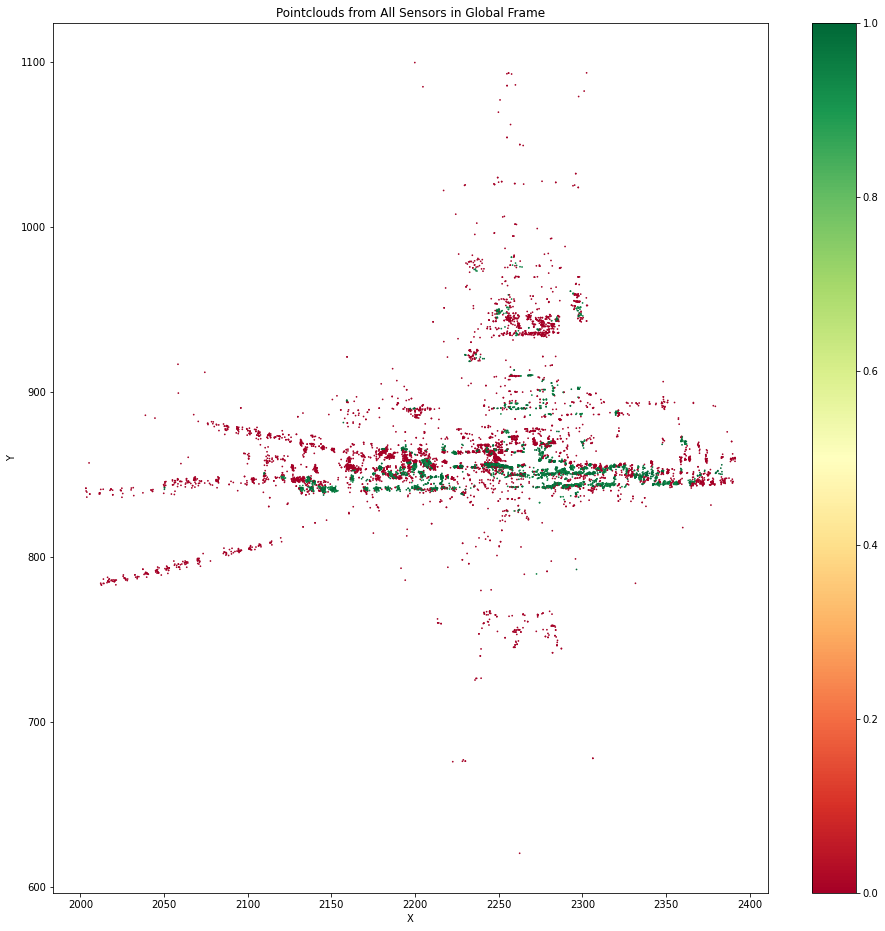

In [12]:
plot_pointclouds(data[:5], [d['ego_pose'] for d in data[:5]])

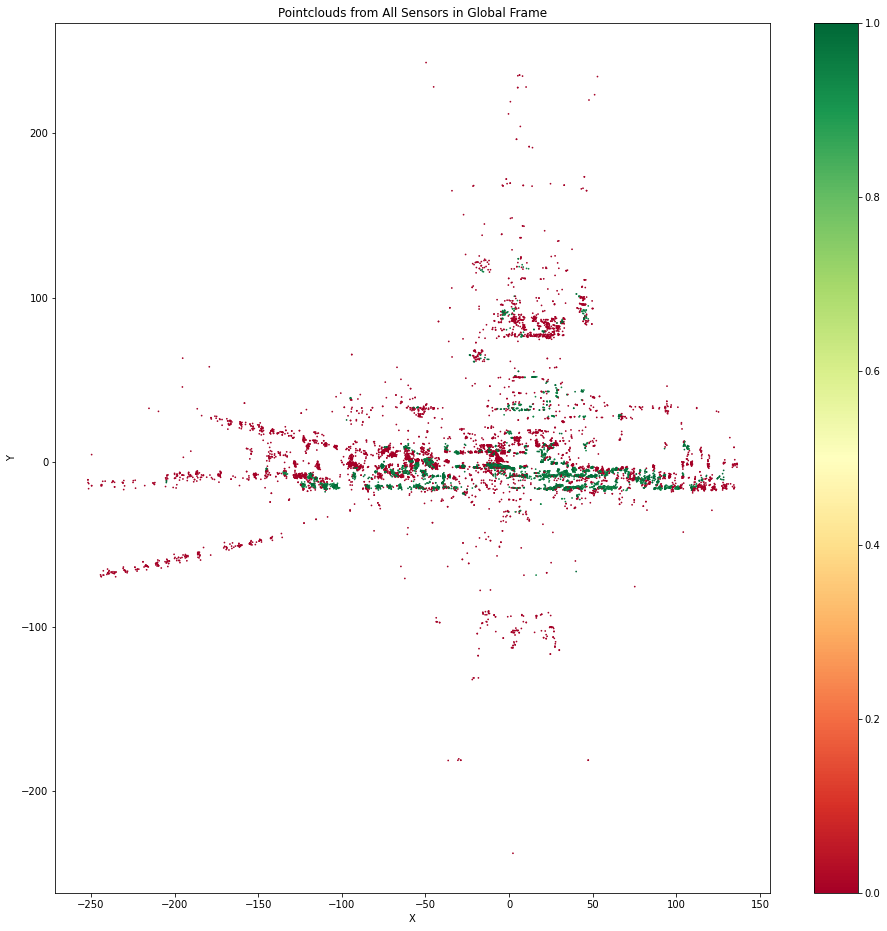

In [13]:
plot_pointclouds(data[:5], [d['ego_local_pose'] for d in data[:5]])

In [7]:
import os
def save_sensor_data(data, sequence_name, base_dir):
    """
    Save the concatenated sensor data to disk in the specified structure.
    
    Parameters:
    - data: The list of sensor data dictionaries.
    - sequence_name: The name of the sequence for which data is being saved.
    - base_dir: The base directory where the data will be saved.
    """
    # Create directories
    sequence_dir = os.path.join(base_dir, "sequence", sequence_name)
    scans_dir = os.path.join(sequence_dir, "scans")
    poses_dir = os.path.join(sequence_dir, "poses")
    local_poses_dir = os.path.join(sequence_dir, "local_poses")
    labels_dir = os.path.join(sequence_dir, "labels")
    map_transform_dir = os.path.join(sequence_dir, "map_transform")

    os.makedirs(scans_dir, exist_ok=True)
    os.makedirs(poses_dir, exist_ok=True)
    os.makedirs(local_poses_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)
    os.makedirs(map_transform_dir, exist_ok=True)

    # Process each element in the data list
    for idx, sensor_data in enumerate(data):
        combined_pointclouds = []
        combined_sps_scores = []
        for sensor in sensor_data:
            if sensor == 'ego_pose' or sensor == 'ego_timestamp' or sensor == 'ego_local_pose':
                continue

            calib_matrix = sensor_data[sensor]['calib']
            pointclouds = sensor_data[sensor]['pointcloud']
            
            transformed_points = transform_doppler_points(calib_matrix, pointclouds)
            combined_pointclouds.append(transformed_points)
            combined_sps_scores.append(sensor_data[sensor]['stability_scores'])

        combined_pointcloud = np.vstack(combined_pointclouds)
        combined_sps_scores = np.hstack(combined_sps_scores)

        assert(combined_sps_scores.shape[0] == combined_pointcloud.shape[0])
        
        # Save combined pointcloud and ego pose
        ego_timestamp = str(np.mean(np.array(sensor_data['ego_timestamp'])))
        scan_file = os.path.join(scans_dir, f"{ego_timestamp}.npy")
        pose_file = os.path.join(poses_dir, f"{ego_timestamp}.txt")
        local_pose_file = os.path.join(local_poses_dir, f"{ego_timestamp}.txt")
        label_file = os.path.join(labels_dir, f"{ego_timestamp}.npy")

        np.save(scan_file, combined_pointcloud)
        np.savetxt(pose_file, sensor_data['ego_pose'], delimiter=',')
        np.savetxt(local_pose_file, sensor_data['ego_local_pose'], delimiter=',')
        np.save(label_file, combined_sps_scores)

        # Save a dummy map_transform file if needed
        map_transform_file = os.path.join(map_transform_dir, "map_transform.txt")
        if not os.path.exists(map_transform_file):
            dummy_transform = np.eye(4)
            np.savetxt(map_transform_file, dummy_transform, delimiter=',')

In [8]:
import shutil
base_dir = "/home/umair/workspace/radar_sps_datasets/nuscenes"

In [ ]:

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)
    os.mkdir(base_dir)
    
src_maps_dir = "/home/umair/workspace/radar_auto_labeler/output_sw5-dpr0.15-r2_combined_maps/labelled_maps/"
dst_maps_dir = os.path.join(base_dir, "maps")
shutil.copytree(src_maps_dir, dst_maps_dir)

In [9]:
## Main loop

for i,row in tqdm(sps_df.iterrows(), total=len(sps_df)):
    ref_scene_name = row['scene_name']
    ref_split = row['split']
    closest_scenes = row['closest_scenes_data']
    seq = int(ref_scene_name.split("-")[-1])


    # dataset_sequence = NuScenesMultipleRadarMultiSweeps(
    #     data_dir=data_dir,
    #     nusc=nuscenes_exp[ref_split],
    #     sequence=seq,
    #     sensors=sensors,
    #     nsweeps=num_sweeps,
    #     ref_frame=ref_frame,
    #     ref_sensor=ref_sensor,
    #     sps_thresh=0.0,
    #     return_sps_scores=True,
    #     sps_labels_dir=sps_maps_dir,
    #     apply_dpr=False,
    #     filter_points=False,
    #     ransac_threshold=-1,
    #     reformat_pcl=False

    # )

    # data = extract_data(dataset_sequence)
    # save_sensor_data(data, ref_scene_name, base_dir)

    for matched_scene, data in closest_scenes.items():
        print(matched_scene)
        print(data)
        assert(0)
        ds = NuScenesMultipleRadarMultiSweeps(
            data_dir=data,
            nusc=nuscenes_exp[data['split']],
            sequence=int(matched_scene.split("-")[-1]),
            sensors=sensors,
            nsweeps=num_sweeps,
            ref_frame=ref_frame,
            ref_sensor=ref_sensor,
            apply_dpr=False,
            filter_points=False,
            ransac_threshold=-1,
            reformat_pcl=False
        )
        data = extract_data(dataset_sequence)
        save_sensor_data(data, ref_scene_name, base_dir)


  0%|          | 0/102 [00:00<?, ?it/s]

scene-0665
{'scene_token': '45275e709d4a4b0592d57850d8e8bd8d', 'matching_indices': [[15, 19], [16, 20], [17, 26], [18, 26], [19, 27], [20, 27], [21, 27], [22, 27], [23, 27], [24, 27], [25, 27], [26, 27], [27, 27], [28, 27], [29, 27], [30, 27], [31, 27], [32, 27], [33, 28], [34, 28], [35, 28], [36, 29], [37, 29]], 'split': 'trainval', 'days_passed': 99, 'hours_passed': 2381.1668846192, 'mean_distance': 1.0114207751, 'trajectory_similarity': 0.9251144706000001, 'first_match_timestamp': 1535487471267159, 'last_match_timestamp': 1535487482275704}


AssertionError: 

In [ ]:
def combine_maps(sps_maps_dir):
    """
    Combines all .asc maps from the given directory into a single map and writes it to disk.
    
    Parameters:
    - sps_maps_dir: The directory containing the .asc map files.
    """
    combined_data = []

    # Iterate through all .asc files in the directory
    for file_name in os.listdir(sps_maps_dir):
        if file_name.endswith(".asc"):
            file_path = os.path.join(sps_maps_dir, file_name)
            # Read the .asc file
            data = np.loadtxt(file_path, skiprows=1)
            combined_data.append(data)
    
    # Combine all the data into a single array
    combined_data = np.vstack(combined_data)
    
    # Determine the output file path one level up from sps_maps_dir
    parent_dir = os.path.abspath(os.path.join(sps_maps_dir, os.pardir))
    output_file = os.path.join(parent_dir, "combined_map.asc")
    
    # Write the combined data to a new .asc file
    np.savetxt(output_file, combined_data, fmt="%.6f")
    print(f"Combined map saved to {output_file}")
    return combined_data

In [ ]:
full_map = combine_maps(sps_maps_dir)

In [ ]:
full_map = np.load('/home/umair/workspace/radar_auto_labeler/notebooks/boston-seaport_sps.asc',)

In [ ]:
import matplotlib.pyplot as plt
# Create scatter plot
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111)
sc = ax.scatter(full_map[:, 0], full_map[:, 1], c=full_map[:,-1], cmap='RdYlGn', s=0.01)

ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.colorbar(sc)
plt.title('Pointclouds from All Sensors in Global Frame')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
# Create scatter plot
sps_only_map = full_map[full_map[:,-1] > 0.0]

fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111)
sc = ax.scatter(sps_only_map[:, 0], sps_only_map[:, 1], c=sps_only_map[:,-1], cmap='RdYlGn', s=0.01)

ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.colorbar(sc)
plt.title('Pointclouds from All Sensors in Global Frame')
plt.show()